In [16]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import sys
sys.path.append('../src')
from sharedcontrolpaper.utils import get_subject_label, string_to_numbers, plot_trial_pressure_individual, process_trial_data_without_minimum_ssrt

In [17]:
%store -r shared_control_metrics

## Supplemental Figure 1

In [18]:
parent_directory = os.path.dirname(os.getcwd())
data_path = os.path.join(parent_directory, 'data', 'experiment')
exp_stage = "pilot"
task = "shared_control"
pattern = os.path.join(data_path, exp_stage, '*', task, '*.csv')
pilot_files = glob.glob(pattern)

exp_stage = "final"
pattern = os.path.join(data_path, exp_stage, '*', task, '*.csv')
data_files = glob.glob(pattern)

In [19]:
def get_data(data_files, exp_stage="final"):
    data = {}
    for file in data_files:
        subject = get_subject_label(file)
        df = pd.read_csv(file)
        df['phase_raw'] = df['phase_raw'].str.strip("'")
        df['block_raw'] = df['block_raw'].str.strip("'")

        df_test = df.query("phase_raw == 'test'")
        block_1 = df_test.query("block_raw == 'block 1'")
        block_2 = df_test.query("block_raw == 'block 2'")
        block_1 = block_1.reset_index(drop=True)
        block_2 = block_2.reset_index(drop=True)

        task_dfs = [block_1, block_2]

        for df in task_dfs:
            if 'ai' in df['condition'].values:
                ai_data = df.copy()
                ai_data['distances_raw'] = ai_data['distances_raw'].apply(string_to_numbers)
                ai_data['pressures_raw'] = ai_data['pressures_raw'].apply(string_to_numbers)
                ai_data['time_stamps_raw'] = ai_data['time_stamps_raw'].apply(string_to_numbers)
            else:
                control_data = df.copy()
                control_data['distances_raw'] = control_data['distances_raw'].apply(string_to_numbers)
                control_data['pressures_raw'] = control_data['pressures_raw'].apply(string_to_numbers)
                control_data['time_stamps_raw'] = control_data['time_stamps_raw'].apply(string_to_numbers)

        data[subject] = {'ai': {'data': ai_data}, 'control': {'data': control_data}}

        for block in data[subject].keys():
            trial_results, ssrt_list = process_trial_data_without_minimum_ssrt(data[subject][block]['data'], exp_stage)
            data[subject][block]['trial_results'] = trial_results
            data[subject][block]['ssrt_list'] = ssrt_list  
    return data

In [20]:
data = get_data(data_files)
pilot_data = get_data(pilot_files, "pilot")

In [21]:
def get_df_ssrt_stop_onset(data_files, data):
    all_data = []
    for file in data_files:
        subject = get_subject_label(file)
        df = pd.read_csv(file)
        trial_results = data[subject]['control']['trial_results']
        for trial in trial_results.values():
            ssrt = trial['ssrt']
            stop_onset = trial['stop_onset']
            all_data.append({'subject': subject, 'ssrt': ssrt, 'stop_onset': stop_onset})

    df = pd.DataFrame(all_data)
    return df

In [22]:
def plot_ssrt(data_files, data, exp_stage="final"):
    df = get_df_ssrt_stop_onset(data_files, data)
    min_ssrt = df['ssrt'].min() * 1000  # Convert to milliseconds
    max_ssrt = df['ssrt'].max() * 1000 

    if exp_stage == "pilot": 
        bin_edges = np.arange(min_ssrt, max_ssrt + 5, 5)

        plt.figure(figsize=(10, 5))
        plt.hist(df['ssrt'] * 1000, bins=bin_edges, alpha=0.7)
        plt.axvline(x=175, color='red', linestyle='dashed', linewidth=1, label='175ms')
        plt.xlabel('SSRT (ms)')
        plt.ylabel('Frequency')
        plt.title('Histogram of SSRT Without a Buffer Period in Pilot Subjects')
        plt.legend()
        plt.gca().xaxis.set_major_locator(MultipleLocator(50))
        plt.gca().xaxis.set_minor_locator(MultipleLocator(5))
        plt.savefig(f'{parent_directory}/figures/figureS1a.png')
        plt.show()

    else:
        plt.figure(figsize=(10, 5))
        df_below_06 = df[df['ssrt'] <= 0.6] # Show values below .6s to avoid the two outliers
        plt.hist(df_below_06['ssrt'] * 1000, bins=np.arange(min_ssrt, 530 + 5, 5), alpha=0.7)
        plt.axvline(x=175, color='red', linestyle='dashed', linewidth=1, label='175ms')
        plt.xlabel('SSRT (ms)')
        plt.ylabel('Frequency')
        plt.title('Histogram of SSRT Values Without a Buffer Below 550ms')
        plt.legend()
        plt.gca().xaxis.set_major_locator(MultipleLocator(50))
        plt.gca().xaxis.set_minor_locator(MultipleLocator(5))
        plt.savefig(f'{parent_directory}/figures/figureS1b.png')
        plt.show()

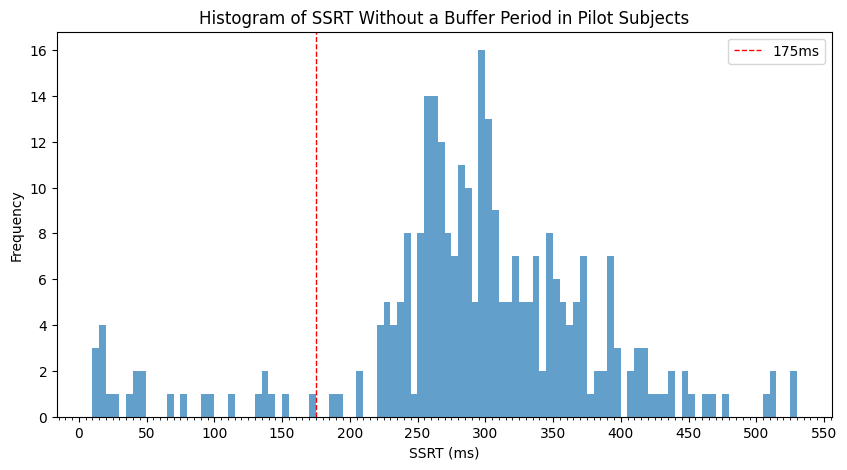

In [23]:
plot_ssrt(pilot_files, pilot_data, exp_stage="pilot")

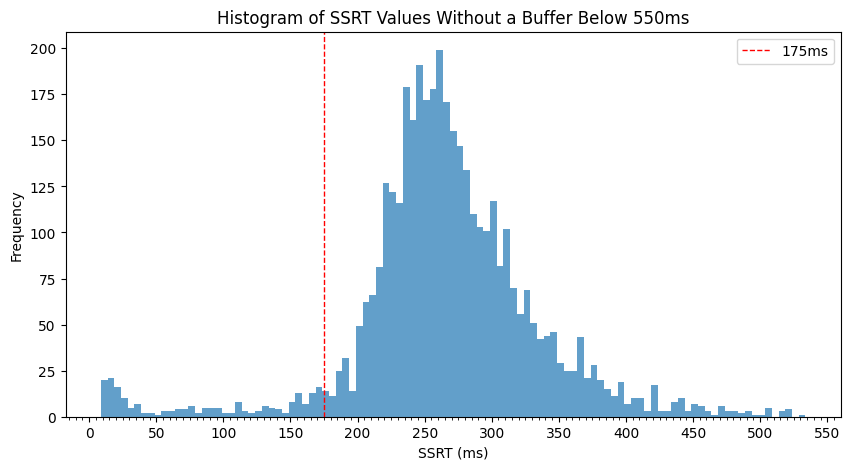

In [24]:
plot_ssrt(data_files, data)

## Supplemental Figure 2

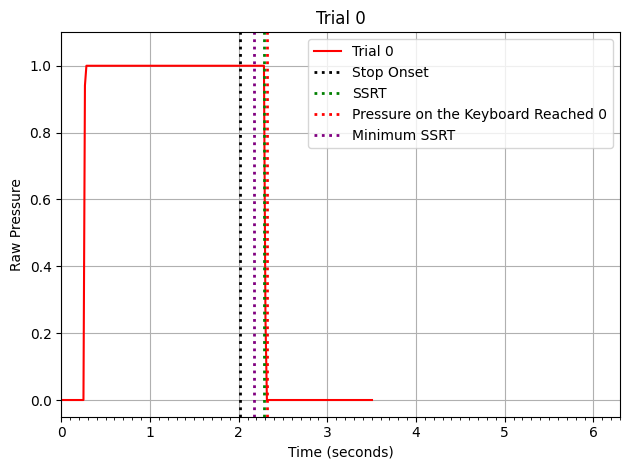

In [25]:
trial_results = shared_control_metrics['s027']['non_ai']['trial_results']
first_non_ai_trial = None
for trial_number, trial_data in trial_results.items():
    first_non_ai_trial = (trial_number, trial_data)
    break

if first_non_ai_trial:
    trial_number, trial_data = first_non_ai_trial
    ax = plt.gca()
    plot_trial_pressure_individual(trial_data, trial_number, ax, color='red')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Raw Pressure')
    plt.savefig(f'{parent_directory}/figures/figureS2.png')
    plt.tight_layout()
    plt.show()

## Supplemental Figure 3

In [26]:
%store -r survey_scores
%store -r survey_results

Mapping of Question Numbers to Original Questions:
Q1: AI is making our daily lives easier.
Q2: I believe that increased use of artificial intelligence will make the world a safer place.
Q3: I trust a self driving car to drive safer than I would normally.
Q4: I trust artificial intelligence.
Q5: I trust companies that do not use AI over companies that do.
Q6: I would prefer to drive a self-driving car over a regular car.
Q7: More vehicles, software, and appliances should make use of AI.


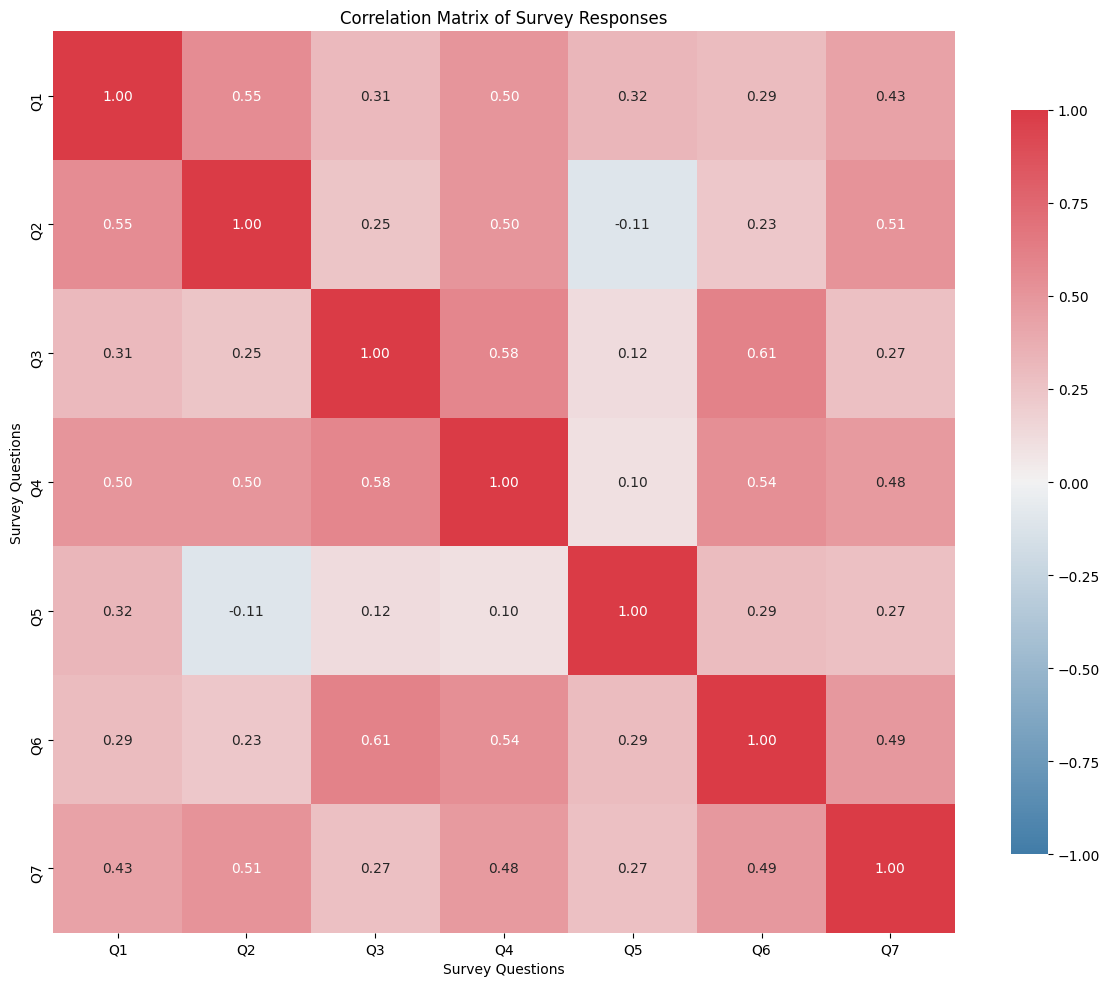

In [27]:
# Step 1: Extract corrected values into a DataFrame
combined_data = []

for subject_id, details in survey_results.items():
    df = details['data']
    for idx, row in df.iterrows():
        combined_data.append({'subject_id': subject_id, 'text': row['text'], 'corrected_value': row['corrected_value']})

# Step 2: Create a pivot DataFrame
pivot_df = pd.DataFrame(combined_data)
pivot_df = pivot_df.pivot(index='subject_id', columns='text', values='corrected_value')

# Step 3: Create a mapping from question number to original questions
question_mapping = {f'Q{i + 1}': question for i, question in enumerate(pivot_df.columns)}

print("Mapping of Question Numbers to Original Questions:")
for q_num, original_question in question_mapping.items():
    print(f"{q_num}: {original_question}")

# Step 4: Rename the columns to Q1, Q2, ..., Q7
new_columns = [f'Q{i + 1}' for i in range(len(pivot_df.columns))]
pivot_df.columns = new_columns

# Step 5: Calculate the correlation matrix
correlation_matrix = pivot_df.corr()

# Step 6: Create a heatmap of the correlation matrix
cmap = sns.diverging_palette(240, 10, as_cmap=True)

plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, center=0, square=True, 
            cbar_kws={"shrink": .8}, vmin=-1, vmax=1, annot_kws={"size": 10}) 

plt.title("Correlation Matrix of Survey Responses")
plt.xlabel("Survey Questions")
plt.ylabel("Survey Questions")

tick_positions = np.arange(len(new_columns)) + 0.5
plt.xticks(ticks=tick_positions, labels=new_columns)
plt.yticks(ticks=tick_positions, labels=new_columns)

plt.tight_layout()

plt.savefig(f'{parent_directory}/figures/figureS3.png', dpi=300) 
plt.show()

## Supplemental Figure 4

In [28]:
# List of survey question column names
question_list = [
    "AI is making our daily lives easier.",
    "I believe that increased use of artificial intelligence will make the world a safer place.",
    'I trust a self driving car to drive safer than I would normally.',
    "I trust artificial intelligence.",
    "I trust companies that do not use AI over companies that do.",
    "I would prefer to drive a self-driving car over a regular car.",
    "More vehicles, software, and appliances should make use of AI."
]

def frequency_of_responses_to_survey(questions, survey_results):
    """
    Generate a grid of bar charts of responses for a list of survey questions.
    
    Parameters:
    - questions: A list of survey question texts.
    - survey_results: A dictionary containing survey responses with subject ID mapping.
    """
    num_questions = len(questions)
    cols = 3  # Number of columns for the grid
    rows = (num_questions + cols - 1) // cols  # Calculate number of rows needed for the grid

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for i, column_name in enumerate(questions):
        # Handle reverse coding for the specific question
        if column_name == "I trust companies that do not use AI over companies that do.":
            survey_results[column_name] = 6 - survey_results[column_name]

        # Count responses
        response_counts = np.bincount(survey_results[column_name].dropna().astype(int), minlength=6)[1:]  # Count of responses excluding 0

        # Plot frequency of responses in the corresponding subplot
        axes[i].bar(np.arange(1, 6), response_counts, color='skyblue', edgecolor='black', alpha=0.7)
        axes[i].set_xticks(np.arange(1, 6))
        axes[i].set_xlabel("Survey Response")
        axes[i].set_ylabel("Frequency")
        axes[i].set_title(f'Q{i + 1}')
        axes[i].grid(axis='y')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(f'{parent_directory}/figures/figureS4.png', dpi=300) 
    plt.show()

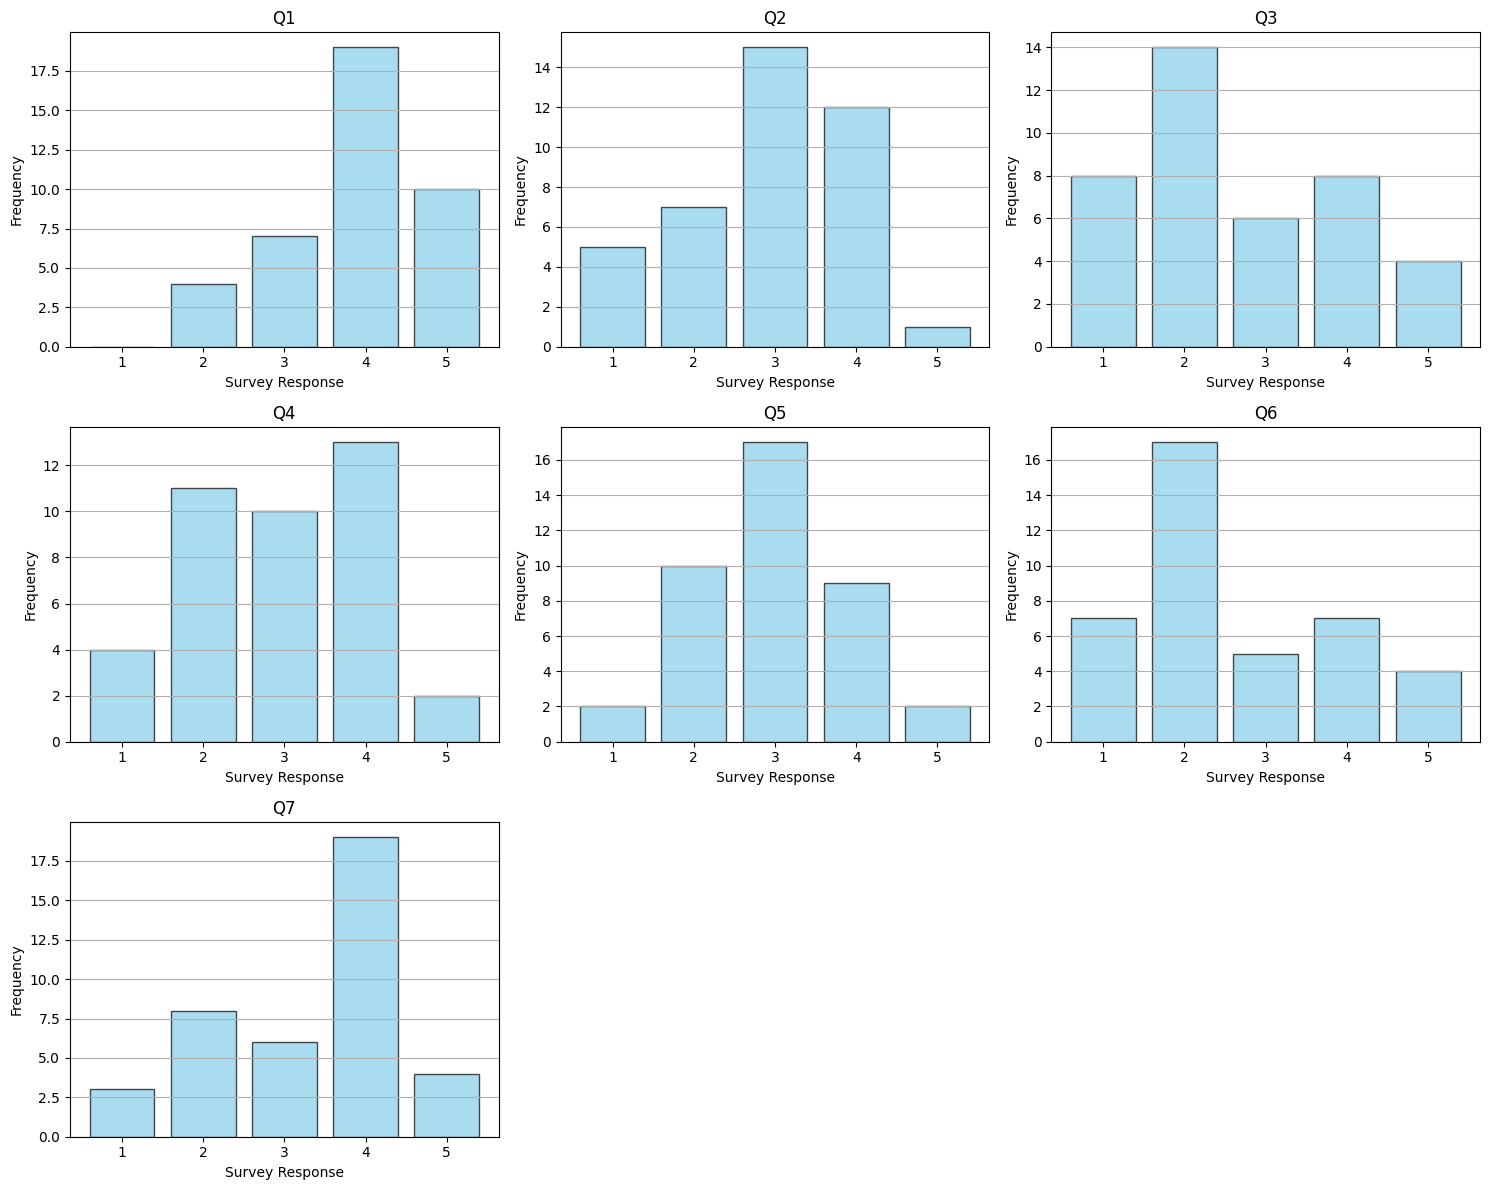

In [29]:
frequency_of_responses_to_survey(question_list, survey_scores)